<a href="https://colab.research.google.com/github/aztofighi/Persian_Handwritten_Recognition/blob/main/Persian_Handwritten_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -q https://github.com/aztofighi/Persian_Handwritten_Recognition/raw/main/Hoda_Dataset/Test_20000.cdb
!wget -q https://github.com/aztofighi/Persian_Handwritten_Recognition/raw/main/Hoda_Dataset/Train_60000.cdb

In [1]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as image
import urllib.request

import tensorflow as tf
import random
import struct
import numpy as np
import cv2



In [2]:
# Get the Train and Test data
TRAIN_PATH = 'Train_60000.cdb'
TEST_PATH = 'Test_20000.cdb'
dataset_url = 'https://github.com/aztofighi/Persian_Handwritten_Recognition/raw/main/Hoda_Dataset/'
for i in [TRAIN_PATH,TEST_PATH]:
  urllib.request.urlretrieve(dataset_url+i, i)

# Image preprocessing

In [3]:
def __convert_to_one_hot(vector, num_classes):
    result = np.zeros(shape=[len(vector), num_classes])
    result[np.arange(len(vector)), vector] = 1
    return result


def __resize_image(src_image, dst_image_height, dst_image_width):
    src_image_height = src_image.shape[0]
    src_image_width = src_image.shape[1]

    if src_image_height > dst_image_height or src_image_width > dst_image_width:
        height_scale = dst_image_height / src_image_height
        width_scale = dst_image_width / src_image_width
        scale = min(height_scale, width_scale)
        img = cv2.resize(src=src_image, dsize=(0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    else:
        img = src_image

    img_height = img.shape[0]
    img_width = img.shape[1]

    dst_image = np.zeros(shape=[dst_image_height, dst_image_width], dtype=np.uint8)

    y_offset = (dst_image_height - img_height) // 2
    x_offset = (dst_image_width - img_width) // 2

    dst_image[y_offset:y_offset+img_height, x_offset:x_offset+img_width] = img

    return dst_image


def read_hoda_cdb(file_name):
    with open(file_name, 'rb') as binary_file:

        data = binary_file.read()

        offset = 0

        # read private header

        yy = struct.unpack_from('H', data, offset)[0]
        offset += 2

        m = struct.unpack_from('B', data, offset)[0]
        offset += 1

        d = struct.unpack_from('B', data, offset)[0]
        offset += 1

        H = struct.unpack_from('B', data, offset)[0]
        offset += 1

        W = struct.unpack_from('B', data, offset)[0]
        offset += 1

        TotalRec = struct.unpack_from('I', data, offset)[0]
        offset += 4

        LetterCount = struct.unpack_from('128I', data, offset)
        offset += 128 * 4

        imgType = struct.unpack_from('B', data, offset)[0]  # 0: binary, 1: gray
        offset += 1

        Comments = struct.unpack_from('256c', data, offset)
        offset += 256 * 1

        Reserved = struct.unpack_from('245c', data, offset)
        offset += 245 * 1

        if (W > 0) and (H > 0):
            normal = True
        else:
            normal = False

        images = []
        labels = []

        for i in range(TotalRec):

            StartByte = struct.unpack_from('B', data, offset)[0]  # must be 0xff
            offset += 1

            label = struct.unpack_from('B', data, offset)[0]
            offset += 1

            if not normal:
                W = struct.unpack_from('B', data, offset)[0]
                offset += 1

                H = struct.unpack_from('B', data, offset)[0]
                offset += 1

            ByteCount = struct.unpack_from('H', data, offset)[0]
            offset += 2

            image = np.zeros(shape=[H, W], dtype=np.uint8)

            if imgType == 0:
                # Binary
                for y in range(H):
                    bWhite = True
                    counter = 0
                    while counter < W:
                        WBcount = struct.unpack_from('B', data, offset)[0]
                        offset += 1
                        # x = 0
                        # while x < WBcount:
                        #     if bWhite:
                        #         image[y, x + counter] = 0  # Background
                        #     else:
                        #         image[y, x + counter] = 255  # ForeGround
                        #     x += 1
                        if bWhite:
                            image[y, counter:counter + WBcount] = 0  # Background
                        else:
                            image[y, counter:counter + WBcount] = 255  # ForeGround
                        bWhite = not bWhite  # black white black white ...
                        counter += WBcount
            else:
                # GrayScale mode
                data = struct.unpack_from('{}B'.format(W * H), data, offset)
                offset += W * H
                image = np.asarray(data, dtype=np.uint8).reshape([W, H]).T

            images.append(image)
            labels.append(label)

        return images, labels


def read_hoda_dataset(dataset_path, images_height=32, images_width=32, one_hot=False, reshape=True):
    images, labels = read_hoda_cdb(dataset_path)
    assert len(images) == len(labels)

    X = np.zeros(shape=[len(images), images_height, images_width], dtype=np.float32)
    Y = np.zeros(shape=[len(labels)], dtype=int)

    #cnt=0

    for i in range(len(images)):
        image = images[i]
        # Image resizing.
        image = __resize_image(src_image=image, dst_image_height=images_height, dst_image_width=images_width)
        # Image normalization.
        image = image / 255
        # Image binarization.
        image = np.where(image >= 0.5, 1, 0)
        # Image.
        X[i] = image
        # Label.
        Y[i] = labels[i]
        #print(type(image))
        #print(image.shape)
        
        #cnt+=1
        #plt.imsave('img_'+str(Y[i])+'_'+str(cnt)+'.png', np.array(image).reshape(32,32), cmap=cm.gray)

    if one_hot:
        Y = __convert_to_one_hot(Y, 10).astype(dtype=np.float32)
    else:
        Y = Y.astype(dtype=np.float32)

    if reshape:
        X = X.reshape(-1, images_height * images_width)
    else:
        X = X.reshape(-1, images_height, images_width, 1)

    return X, Y


In [4]:
X_train, Y_train = read_hoda_dataset(dataset_path=TRAIN_PATH,
                                    images_height=32,
                                    images_width=32,
                                    one_hot=False,
                                    reshape=True)



print(X_train.shape, Y_train.shape)


(60000, 1024) (60000,)


In [5]:
X_test, Y_test = read_hoda_dataset(dataset_path=TEST_PATH,
                                  images_height=32,
                                  images_width=32,
                                  one_hot=False,
                                  reshape=True)
print(X_test.shape, Y_test.shape)

(20000, 1024) (20000,)


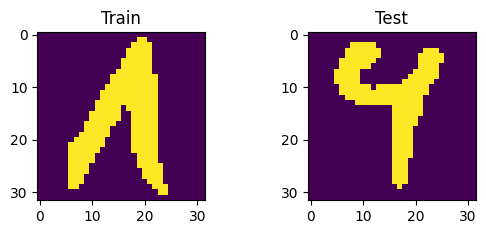

In [6]:
# Plot the Train and Test data
img1 = plt.subplot(221)
train_index = random.randint(0, len(X_train))
test_index = random.randint(0, len(X_test))
img1.set_title('Train')
plt.imshow(X_train[train_index].reshape(32,32))
img2 = plt.subplot(222)
plt.imshow(X_test[test_index].reshape(32,32))
img2.set_title('Test')

plt.show()

In [7]:
# X_train = np.expand_dims(X_train, axis=2)
# X_test = np.expand_dims(X_test, axis=2)

# Normalize the Train and Test data
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# one hot encode outputs
Y_train = np_utils.to_categorical(Y_train)
Y_test = np_utils.to_categorical(Y_test)
num_classes = Y_test.shape[1]
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(60000, 1024) (20000, 1024) (60000, 10) (20000, 10)


In [9]:
# Build model
def build_model():
  model = Sequential()
  model.add(Dense(100, input_shape=(32 * 32,), activation='relu'))
  model.add(Dropout(0.02))
  model.add(Dense(400, activation='relu'))
  model.add(Dense(num_classes, activation='sigmoid'))
  return model

In [10]:
def recall_m(y_true, y_pred):
    K = tf.keras.backend
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    K = tf.keras.backend
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    K = tf.keras.backend
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [17]:
model = build_model()
# Compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=10, batch_size=200)

Epoch 1/10
300/300 [==============================] - 3s 7ms/step - loss: 0.8884 - accuracy: 0.7749 - val_loss: 0.4912 - val_accuracy: 0.8418
Epoch 2/10
300/300 [==============================] - 2s 7ms/step - loss: 0.2427 - accuracy: 0.9300 - val_loss: 0.3734 - val_accuracy: 0.8837
Epoch 3/10
300/300 [==============================] - 2s 7ms/step - loss: 0.1861 - accuracy: 0.9468 - val_loss: 0.3133 - val_accuracy: 0.9060
Epoch 4/10
300/300 [==============================] - 2s 8ms/step - loss: 0.1574 - accuracy: 0.9559 - val_loss: 0.2807 - val_accuracy: 0.9174
Epoch 5/10
300/300 [==============================] - 2s 8ms/step - loss: 0.1373 - accuracy: 0.9612 - val_loss: 0.2591 - val_accuracy: 0.9252
Epoch 6/10
300/300 [==============================] - 2s 7ms/step - loss: 0.1238 - accuracy: 0.9650 - val_loss: 0.2293 - val_accuracy: 0.9341
Epoch 7/10
300/300 [==============================] - 2s 6ms/step - loss: 0.1102 - accuracy: 0.9692 - val_loss: 0.2165 - val_accuracy: 0.9374
Epoch 

In [18]:
# Final evaluation of the model
train_eval = model.evaluate(X_train, Y_train, batch_size=200)
test_eval = model.evaluate(X_test, Y_test, batch_size=200)
print("Train eval : ", train_eval)
print("Test eval : ", test_eval)
model.save("hoda.h5")

100/100 [==============================] - 0s 2ms/step - loss: 0.1765 - accuracy: 0.9494
Train eval :  [0.07298439741134644, 0.9797333478927612]
Test eval :  [0.17647260427474976, 0.949400007724762]


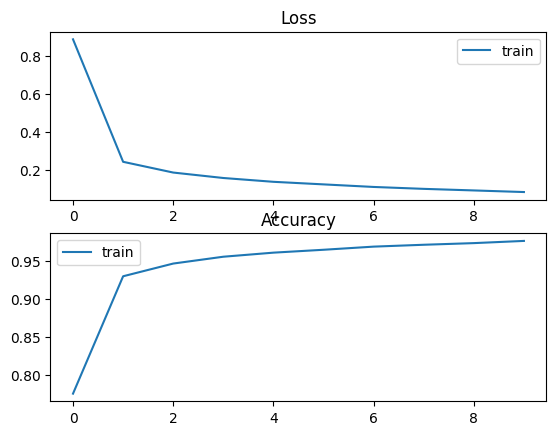

In [19]:
# Plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.legend()

# Plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.legend()

plt.show()


In [20]:
Y_pred = model.predict(X_test, batch_size=200, verbose=1)
print(Y_pred)
print(Y_test)
Y_pred_bool = np.argmax(Y_pred, axis=1)

100/100 [==============================] - 0s 3ms/step
[[9.9906689e-01 5.9854653e-02 1.0912608e-03 ... 2.5951442e-01
  1.4703901e-01 1.4564692e-02]
 [9.9943089e-01 1.5230115e-01 3.2378390e-04 ... 2.6052395e-01
  5.0317645e-01 3.1789201e-03]
 [9.1068250e-01 8.0263841e-01 4.2169003e-04 ... 5.9823710e-01
  4.6834525e-02 6.9842166e-03]
 ...
 [2.7150951e-02 9.7668225e-01 1.4849089e-01 ... 1.3031462e-03
  2.7758700e-03 4.7707412e-01]
 [1.1448774e-03 2.6336296e-03 5.1102787e-03 ... 7.9475745e-07
  4.5288196e-01 9.9991417e-01]
 [1.1456207e-05 2.0091527e-05 2.3876399e-01 ... 6.2753731e-09
  1.2617725e-01 9.9999785e-01]]
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [21]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(Y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)

print('Confusion Matrix')
print(confusion_matrix(y_true, y_pred))
print('Classification Report')
target_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
print(classification_report(y_true, y_pred, target_names=target_names))

Confusion Matrix
[[1972    0    0    0    4   18    3    3    0    0]
 [   4 1969   11    0    3    0    7    3    1    2]
 [   0   34 1866   46   24    0   18    2    0   10]
 [   6    2  115 1789   75    0    8    2    0    3]
 [   6    5   22   76 1848   12   11    2    2   16]
 [   5    6    1    3   18 1945    4    8    9    1]
 [   4   13   24    3   18    6 1876   10    5   41]
 [  14    7   22    2    8   13   16 1918    0    0]
 [   6    3    5    0   18   10   12    0 1919   27]
 [   2   36   18    2    7    3   33    0   13 1886]]
Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2000
           1       0.95      0.98      0.97      2000
           2       0.90      0.93      0.91      2000
           3       0.93      0.89      0.91      2000
           4       0.91      0.92      0.92      2000
           5       0.97      0.97      0.97      2000
           6       0.94      0.94      0.94      20

## Loading the saved model

In [22]:
from tensorflow.keras.models import load_model
model_load  = load_model('hoda.h5')

## predict a sample image

1/1 [==============================] - 0s 40ms/step


2

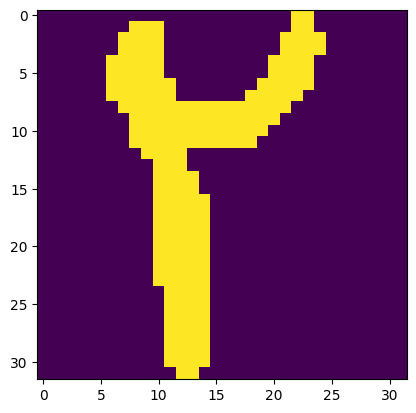

In [23]:
# predict a sample image
test_index = random.randint(0, len(X_test))
plt.imshow(X_test[test_index].reshape(32,32))
img2.set_title('Test')
model_load.predict(X_test[test_index].reshape(1,1024)).argmax()

## predict an RGB sample image

In [24]:
#download sample handwritten Persian digits
sample_url = 'https://raw.githubusercontent.com/aztofighi/Persian_Handwritten_Recognition/main/Samples/'
for i in range(0,10):
  urllib.request.urlretrieve(sample_url+str(i)+'sample.png', str(i)+'sample.png')

In [25]:
def classify_sample(model_name, file_name):
  model_load  = load_model(model_name)
  sample_img = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)
  # Convert image to grayscale
  img_blur = cv2.medianBlur(sample_img,5)
  ret2,img_bin2 = cv2.threshold(img_blur,0,1,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  # Invert binary image
  img_bin2 = 1 - img_bin2
  img_bin2 = img_bin2/255
  # Find the outermost pixels
  non_zero_pixels = cv2.findNonZero(img_bin2)
  x, y, w, h = cv2.boundingRect(non_zero_pixels)
  left = x
  top = y
  right = x + w
  bottom = y + h

  # Calculate the maximum dimension of the bounding rectangle
  max_dim = max(right - left, bottom - top)

  # Calculate padding to make the image square
  padding = int((max_dim - min(w, h)) / 2)

  # Add padding to the bounding rectangle
  left -= padding
  top -= padding
  right += padding
  bottom += padding

  # Ensure the coordinates are within the image boundaries
  left = max(0, left)
  top = max(0, top)
  right = min(img_bin2.shape[1], right)
  bottom = min(img_bin2.shape[0], bottom)

  # Crop the image to the bounding rectangle
  cropped_image = img_bin2[top:bottom, left:right]

  # Resize the image to 32x32 pixels
  resized_image = cv2.resize(cropped_image, (32, 32))

  resized_image = resized_image.astype('float32')
  predicted_class = model_load.predict(resized_image.reshape(1,1024)).argmax()
  return sample_img, resized_image, str(predicted_class)



1/1 [==============================] - 0s 78ms/step
Image Class: 4


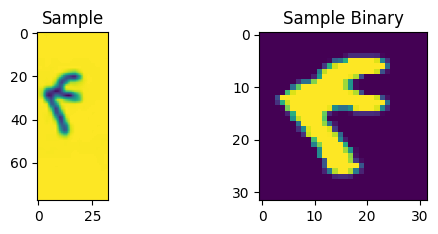

In [26]:
img_in, img_out, img_class = classify_sample('hoda.h5','4sample.png')
print("Image Class: " + img_class)
# Plot the Train and Test data
img1 = plt.subplot(221)
img1.set_title('Sample')
plt.imshow(img_in)
img2 = plt.subplot(222)
plt.imshow(img_out.reshape(32,32))
img2.set_title('Sample Binary')
plt.show()